# Worksheet 17

Name:  Sangheon Jeong
UID: 72771619

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

One possible method is User Based Collaborative Filtering. Similarity Calculation: Instead of using Pearson correlation or cosine similarity of ratings, use similarity measures suitable for binary data such as Jaccard similarity or Hamming distance. Jaccard similarity, for example, measures the intersection over union of liked items between users. Prediction: Aggregate the likes of similar users to predict whether the target user might like a particular item. Essentially, if many similar users like an item, it’s recommended to the user.

b) Describe 3 challenges of building a recommender system

1. For new users and items, there are not enough data for the model to give a prediction
2. Most users interact with only a small fraction of the total items in a system, resulting in a user-item interaction matrix that is extremely sparse. This sparsity complicates the task of finding meaningful patterns in the data.
3. Lack of diversity for the user might also be a problem. Users are recommended items too similar to their past preferences, potentially leading to boredom.

c) Why is SVD not an option for collaborative filtering?

SVD genearlly requires a dense matrix, but user item matrices in collaborative filtering are typically very sparse. SVD does not perfom weel with high levels of sparsity unless modifications are made. Also, applying SVD directly on a sparse matrix with many missing values can lead to overfitting to the observed entries and poor generalization to predict unobserved entries.

d) Use the code below to train a recommender system on a dataset of amazon movies

In [ ]:
%pip install findspark
%pip install pyspark

Kaggle RMSE =  1.4384643418767982


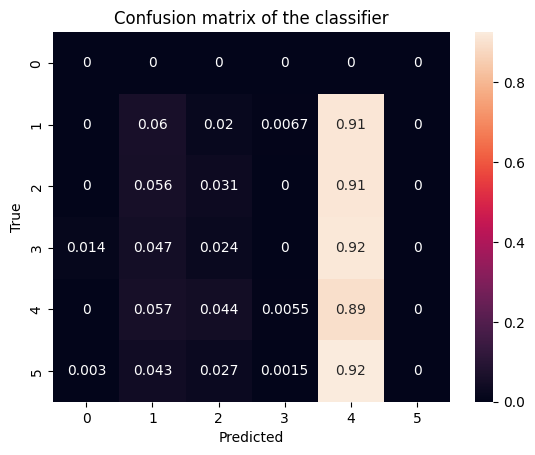

In [11]:
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS

# Initialize findspark and Spark session
findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

# Load the dataset
init_df = pd.read_csv("/content/train (1).csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
    init_df.drop(['Score'], axis=1),
    init_df['Score'],
    test_size=1/4.0,
    random_state=0
)

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])

# Setup and train the ALS model
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
rec_sys = als.fit(df)

# Use the trained model to make predictions on the test set
X_test_processed_spark_df = spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])
predictions = rec_sys.transform(X_test_processed_spark_df).toPandas()
X_test_processed = X_test_processed.reset_index(drop=True)
predictions = predictions.reset_index(drop=True)

result = pd.merge(X_test_processed, predictions, on=['UserId_fact', 'ProductId_fact'], how='left')

average_rating = Y_train.mean()
result['prediction'].fillna(average_rating, inplace=True)
X_test_processed['Score'] = result['prediction'].values

# Evaluate the model using RMSE
rmse = mean_squared_error(Y_test, X_test_processed['Score'], squared=False)
print("Kaggle RMSE = ", rmse)

# Generate and display confusion matrix
cm = confusion_matrix(Y_test.round(), X_test_processed['Score'].round(), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
